# GOING DEEPER 02 : Augmentation

## 준비한 데이터

- Stanford Dogs 데이터셋

## 텐서플로 Random Augmentation 함수 목록

- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

## 0. 라이브러리 import 및 데이터셋 준비

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

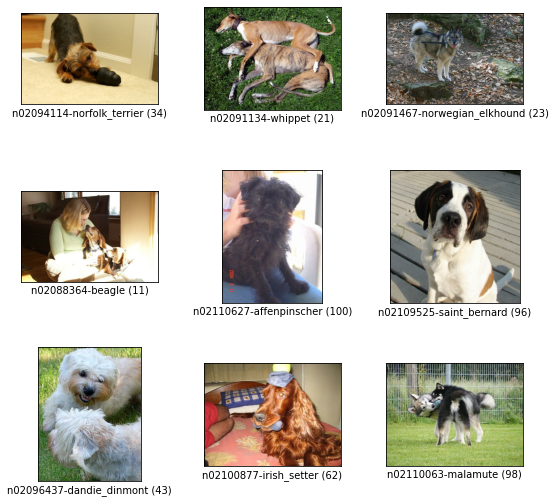

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

## 1. 데이터셋 전처리 함수 정의

In [5]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### CutMix
이미지의 일정 영역을 잘라서 다른 이미지에 붙여주는 방법으로  
배치 내의 이미지를 두 개 골라 바운딩 박스의 위치를 랜덤하게 뽑고  
해당 영역을 잘라내서 두 개의 이미지를 섞어준다.  
섞인 이미지의 전체 이미지 대비 비율을 계산하고  
면적에 비례해서 두 라벨을 섞어준다.

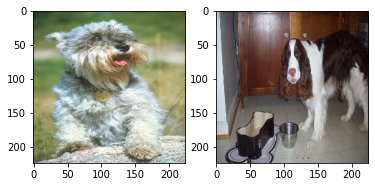

In [9]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [10]:
# 바탕 이미지 a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+height//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(71, shape=(), dtype=int32) tf.Tensor(114, shape=(), dtype=int32) tf.Tensor(179, shape=(), dtype=int32)


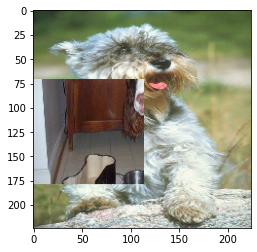

In [11]:
# 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [12]:
# 섞인 이미지의 면적에 비례해서 라벨을 섞어주는 함수
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.7546237 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.24537627, 0.        , 0.        , 0.        ,
       0.     

In [13]:
# 위에서 구현한 두 함수를 활용하여 배치 단위의 cutmix() 함수 구현
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup

두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로  
두 이미지를 섞을 비율을 일정한 범위 내에서 랜덤하게 뽑고  
해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다.

In [14]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.40684414
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.59315586 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

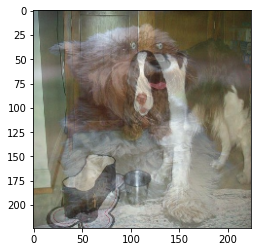

In [15]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [16]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 2. 데이터셋에 적용하기

In [17]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [18]:
# 배치 단위로 데이터셋을 정렬 후 CutMix와 Mixup을 적용할 수 있도록 수정한 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 3. 모델 만들기

In [20]:
# imagenet 데이터에 훈련된 ResNet50 모델 불러오기
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   # 마지막 fully connected layer 미포함
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

In [21]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet 생성
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [22]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 4. 모델 훈련하기

cutmix(), mixup()을 구현하면서  
label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고  
One-Hot 벡터 형태로 변환되었기 때문에  
sparse_categorical_crossentropy 대신 categorical_crossentropy를 사용해야 한다.

In [24]:
EPOCH = 20  # Augemtation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2021)
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [25]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 356s 431ms/step - loss: 3.1564 - accuracy: 0.2771 - val_loss: 3.9880 - val_accuracy: 0.1372
Epoch 2/20
750/750 [==============================] - 326s 435ms/step - loss: 0.8817 - accuracy: 0.7583 - val_loss: 1.2263 - val_accuracy: 0.6469
Epoch 3/20
750/750 [==============================] - 328s 438ms/step - loss: 0.2800 - accuracy: 0.9388 - val_loss: 0.9997 - val_accuracy: 0.7034
Epoch 4/20
750/750 [==============================] - 329s 438ms/step - loss: 0.0769 - accuracy: 0.9918 - val_loss: 0.9017 - val_accuracy: 0.7369
Epoch 5/20
750/750 [==============================] - 329s 439ms/step - loss: 0.0320 - accuracy: 0.9992 - val_loss: 0.9111 - val_accuracy: 0.7407
Epoch 6/20
750/750 [==============================] - 329s 439ms/step - loss: 0.0169 - accuracy: 0.9999 - val_loss: 0.9251 - val_accuracy: 0.7393
Epoch 7/20
750/750 [==============================] - 329s 439ms/step - loss: 0.0125 - accuracy: 0.9999 - val_loss: 0.9332 -

In [27]:
df_resnet50_no_aug = pd.DataFrame({
    'val_loss': history_resnet50_no_aug.history['val_loss'],
    'val_accuracy': history_resnet50_no_aug.history['val_accuracy']
    })
df_resnet50_no_aug.to_csv('/aiffel/aiffel/data/history_resnet50_no_aug.csv', index=False)

In [25]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 365s 447ms/step - loss: 3.1716 - accuracy: 0.2813 - val_loss: 2.6413 - val_accuracy: 0.3324
Epoch 2/20
750/750 [==============================] - 339s 452ms/step - loss: 1.0869 - accuracy: 0.6926 - val_loss: 1.0983 - val_accuracy: 0.6749
Epoch 3/20
750/750 [==============================] - 340s 453ms/step - loss: 0.5841 - accuracy: 0.8353 - val_loss: 1.0253 - val_accuracy: 0.6999
Epoch 4/20
750/750 [==============================] - 340s 453ms/step - loss: 0.2845 - accuracy: 0.9279 - val_loss: 0.9913 - val_accuracy: 0.7154
Epoch 5/20
750/750 [==============================] - 340s 453ms/step - loss: 0.1394 - accuracy: 0.9748 - val_loss: 0.9498 - val_accuracy: 0.7284
Epoch 6/20
750/750 [==============================] - 340s 453ms/step - loss: 0.0755 - accuracy: 0.9903 - val_loss: 0.9209 - val_accuracy: 0.7434
Epoch 7/20
750/750 [==============================] - 340s 453ms/step - loss: 0.0435 - accuracy: 0.9955 - val_loss: 0.9655 -

In [26]:
df_resnet50_aug = pd.DataFrame({
    'val_loss': history_resnet50_aug.history['val_loss'],
    'val_accuracy': history_resnet50_aug.history['val_accuracy']
    })
df_resnet50_aug.to_csv('/aiffel/aiffel/data/history_resnet50_aug.csv', index=False)

In [25]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 370s 451ms/step - loss: 4.3737 - accuracy: 0.1132 - val_loss: 3.6042 - val_accuracy: 0.1686
Epoch 2/20
750/750 [==============================] - 340s 453ms/step - loss: 3.0304 - accuracy: 0.4125 - val_loss: 1.4347 - val_accuracy: 0.6075
Epoch 3/20
750/750 [==============================] - 341s 454ms/step - loss: 2.6768 - accuracy: 0.5148 - val_loss: 1.2347 - val_accuracy: 0.6560
Epoch 4/20
750/750 [==============================] - 341s 454ms/step - loss: 2.4557 - accuracy: 0.5868 - val_loss: 1.3085 - val_accuracy: 0.6444
Epoch 5/20
750/750 [==============================] - 340s 454ms/step - loss: 2.3066 - accuracy: 0.6398 - val_loss: 1.2079 - val_accuracy: 0.6715
Epoch 6/20
750/750 [==============================] - 341s 455ms/step - loss: 2.1784 - accuracy: 0.6792 - val_loss: 1.3036 - val_accuracy: 0.6536
Epoch 7/20
750/750 [==============================] - 341s 454ms/step - loss: 2.0978 - accuracy: 0.7068 - val_loss: 1.3877 -

In [26]:
df_resnet50_cutmix = pd.DataFrame({
    'val_loss': history_resnet50_cutmix.history['val_loss'],
    'val_accuracy': history_resnet50_cutmix.history['val_accuracy']
    })
df_resnet50_cutmix.to_csv('/aiffel/aiffel/data/history_resnet50_cutmix.csv', index=False)

In [27]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 347s 455ms/step - loss: 4.2926 - accuracy: 0.1257 - val_loss: 3.9491 - val_accuracy: 0.1191
Epoch 2/20
750/750 [==============================] - 341s 455ms/step - loss: 2.9829 - accuracy: 0.4322 - val_loss: 1.4773 - val_accuracy: 0.5841
Epoch 3/20
750/750 [==============================] - 341s 455ms/step - loss: 2.6666 - accuracy: 0.5503 - val_loss: 1.6286 - val_accuracy: 0.5556
Epoch 4/20
750/750 [==============================] - 341s 455ms/step - loss: 2.4735 - accuracy: 0.6212 - val_loss: 1.3487 - val_accuracy: 0.6184
Epoch 5/20
750/750 [==============================] - 341s 454ms/step - loss: 2.3557 - accuracy: 0.6712 - val_loss: 1.2866 - val_accuracy: 0.6479
Epoch 6/20
750/750 [==============================] - 340s 454ms/step - loss: 2.1854 - accuracy: 0.7269 - val_loss: 1.2696 - val_accuracy: 0.6549
Epoch 7/20
750/750 [==============================] - 341s 454ms/step - loss: 2.0975 - accuracy: 0.7645 - val_loss: 1.2443 -

In [28]:
df_resnet50_mixup = pd.DataFrame({
    'val_loss': history_resnet50_mixup.history['val_loss'],
    'val_accuracy': history_resnet50_mixup.history['val_accuracy']
    })
df_resnet50_mixup.to_csv('/aiffel/aiffel/data/history_resnet50_mixup.csv', index=False)

## 5. 시각화하기

In [2]:
history_resnet50_no_aug = pd.read_csv('/aiffel/aiffel/data/history_resnet50_no_aug.csv')
history_resnet50_aug = pd.read_csv('/aiffel/aiffel/data/history_resnet50_aug.csv')
history_resnet50_cutmix = pd.read_csv('/aiffel/aiffel/data/history_resnet50_cutmix.csv')
history_resnet50_mixup = pd.read_csv('/aiffel/aiffel/data/history_resnet50_mixup.csv')

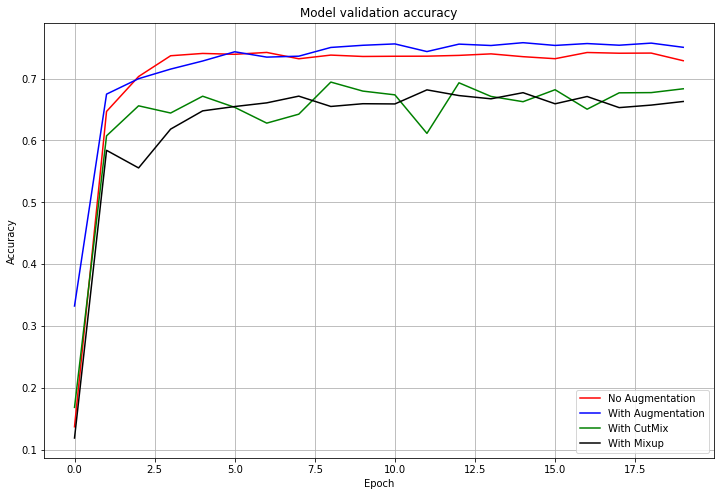

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

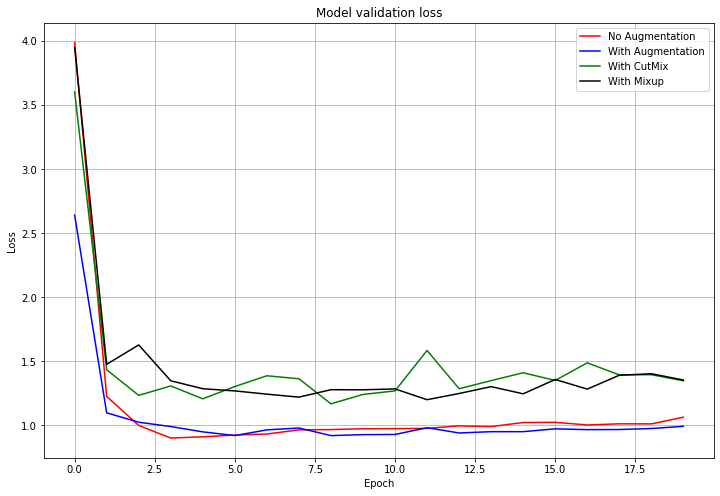

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug['val_loss'], 'r')
plt.plot(history_resnet50_aug['val_loss'], 'b')
plt.plot(history_resnet50_cutmix['val_loss'], 'g')
plt.plot(history_resnet50_mixup['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

In [5]:
acc_data = {'No Augmentation': history_resnet50_no_aug['val_accuracy'], 
            'With Augmentation': history_resnet50_aug['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix['val_accuracy'], 
            'With Mixup': history_resnet50_mixup['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,With Augmentation,With CutMix,With Mixup
0,0.137243,0.332439,0.168610,0.119053
1,0.646922,0.674907,0.607509,0.584072
2,0.703358,0.699860,0.656017,0.555620
3,0.736940,0.715368,0.644356,0.618354
4,0.740672,0.728428,0.671525,0.647855
5,0.739272,0.743354,0.653568,0.654851
6,0.742304,0.734725,0.628032,0.660798
7,0.732043,0.736241,0.642491,0.671642
8,0.737990,0.750350,0.694380,0.654967
9,0.735774,0.753848,0.679804,0.659398


In [6]:
acc_df.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup
count,20.000000,20.000000,20.000000,20.000000
mean,0.701166,0.720435,0.636451,0.624411
std,0.134460,0.093889,0.112849,0.122945
min,0.137243,0.332439,0.168610,0.119053
25%,0.732130,0.733151,0.643890,0.651790
50%,0.736591,0.750466,0.666919,0.659165
75%,0.740147,0.754402,0.677968,0.668260
max,0.742304,0.758046,0.694380,0.681786


# 프로젝트 결과

### Augmentation에 따른 결과값을 비교 

No Augmentation와 With Augmentation부터 비교해보면  
Augmentation을 안한것보다는 Augmentation을 한쪽이  
val_accuracy가 초기부터 높았고 최종적으로도 높은 것을 볼 수 있었다. 

그러나 CutMix나 Mixup을 적용했을때에는  
오히려 Augmentation을 안한 것 보다 훨씬 결과가 안좋았고  
CutMix와 Mixup을 비교했을때는  
그나마 CutMix쪽이 val_accuracy가 더 높은 것을 볼 수 있었다.  

validation loss를 봐도 마찬가지의 결과를 볼 수 있다.

### CutMix나 Mixup의 결과가 안 좋은 이유
CutMix의 결과가 왜 안좋은지 원인을 추측해보자면  

![image](https://user-images.githubusercontent.com/85026563/136190291-9dc8d5d9-4f8b-4bdc-ab50-2e9a91338758.png)
![image](https://user-images.githubusercontent.com/85026563/136190980-3c0daea4-2cc1-4a8b-8182-ae171f1675a1.png)

위 사진처럼 다른 개가 원래 사진의 개를 대부분 가려버리거나  

![image](https://user-images.githubusercontent.com/85026563/136190471-4b11dcd6-b47c-4ad4-a32d-f7b9fd406e4c.png)
![image](https://user-images.githubusercontent.com/85026563/136190789-9190f9ae-8146-4c7a-83a8-84347e575c85.png)

위 사진처럼 개사진의 배경만 가져와서 CutMix를 했거나  

![image](https://user-images.githubusercontent.com/85026563/136191083-062980c6-c2da-461b-b7a8-f7824c5a2b15.png)
![image](https://user-images.githubusercontent.com/85026563/136191257-80df080d-c7be-4bbb-a0dd-dc7c26a2650c.png)

위 사진처럼 데이터셋에 유독 사람이 많이 나오는데 사람의 영향도 있을 것이라고 추측할 수 있을 것 같다.  


그런데 Mixup의 결과는 왜 안좋은지 솔직히 모르겠고  
오히려 결과가 더 좋아야 정상일 것 같은데 아직 원인을 못 찾았다.  
데이터셋 자체에 배경이 차지하는 비율이 높은 사진이 많거나  
사람이 많이 포함되어 있어서 그럴것이라고 심증이 있는데  
그렇다면 데이터셋 자체가 Mixup하기 좋지 않은 것이라고 판단할 수 있을 것 같다.
